In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [57]:
def generate_combinations(feature_columns):
    """
    Generate all possible combinations of a list of feature columns.
    
    Parameters:
    feature_columns (list): A list of feature column names.
    
    Returns:
    list: A list of lists, where each inner list represents a combination of feature columns.
    """
    all_combinations = []
    for r in range(1, len(feature_columns) + 1):
        combinations_r = combinations(feature_columns, r)
        all_combinations.extend(combinations_r)
    
    # Convert each combination from a tuple to a list
    all_combinations_lists = [list(comb) for comb in all_combinations]
    return all_combinations_lists

In [18]:
def load_data_from_dataframe_ann(df):
    # Assuming the last column contains labels
    X = df.iloc[:, :-1].values  # All columns except the last
    y = df.iloc[:, -1].values  # Last column
    
    # Encode labels to integers
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y_encoded, encoder.classes_

# Function to load and preprocess data
def load_data_ann(feature_file, label_file):
    # Load features and labels
    X = np.load(feature_file)
    y = np.load(label_file)
    
    # Encode labels to integers
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y_encoded, encoder.classes_

In [ ]:
def manually_parse_string_to_list(str_series):
    """Converts string representations of arrays into lists of floats."""
    converted_lists = []
    for item in str_series:
        try:
            clean_item = item.strip("[]").split()  # Remove brackets and split by spaces
            lst = [float(num) for num in clean_item if num]  # Convert to float
            converted_lists.append(lst)
        except Exception as e:
            converted_lists.append(None)
            print(f"Failed to convert item: {item[:30]}... Error: {e}")
    return converted_lists

def preprocess_data_ann_acoustic(df):    
    # Convert feature columns from string to list of floats
    for col in ['mfcc', 'lpcc', 'lfpc', 'gfcc', 'formants']:
        df[col] = manually_parse_string_to_list(df[col])

    # Extracting emotion labels from the 'filename' column
    df['emotion'] = df['filename'].apply(lambda x: x.split('_')[-1].split('.')[0])

    # Selecting the feature columns (all except 'filename' and 'emotion')
    feature_columns = df.columns.difference(['filename', 'emotion'])
    X = df[feature_columns]

    # Encoding the emotion labels
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(df['emotion'])

    # Normalizing the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y_encoded, encoder.classes_


def preprocess_data_ann_prosodic(df):
    # Extracting emotion labels from the 'filename' column
    df['emotion'] = df['filename'].apply(lambda x: x.split('_')[-1].split('.')[0])

    # Selecting the feature columns (all except 'filename' and 'emotion')
    feature_columns = df.columns.difference(['filename', 'emotion'])
    X = df[feature_columns]

    # Encoding the emotion labels
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(df['emotion'])

    # Normalizing the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y_encoded, encoder.classes_

In [24]:
# Preprocessing functions
def convert_string_to_array(str_array):
    str_elements = str_array.strip('[]').split()
    return np.array([float(elem) for elem in str_elements])

def pad_sequences_numpy(sequences, maxlen, dtype='float32', padding='post', value=0.0):
    num_samples = len(sequences)
    x = np.full((num_samples, maxlen), value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue
        if padding == 'post':
            x[idx, :len(s)] = s[:maxlen]
        elif padding == 'pre':
            x[idx, -len(s):] = s[-maxlen:]
    return x

def convert_and_aggregate_features_np(df, feature_columns):
    aggregated_features = []
    max_len = 0
    for column in feature_columns:
        df[column + '_processed'] = df[column].apply(convert_string_to_array)
        max_len = max(max_len, df[column + '_processed'].apply(len).max())
    for _, row in df.iterrows():
        aggregated_sample_features = np.concatenate([row[col + '_processed'] for col in feature_columns])
        aggregated_features.append(aggregated_sample_features)
    padded_features = pad_sequences_numpy(aggregated_features, maxlen=max_len, dtype='float32', padding='post', value=0.0)
    return padded_features

def extract_and_encode_labels(df, filename_column):
    labels = df[filename_column].apply(lambda x: x.split('_')[-1].split('.')[0])
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels, label_encoder.classes_

def normalize_features(train_features, test_features):
    mean = np.mean(train_features, axis=0)
    std = np.std(train_features, axis=0)
    std[std == 0] = 1
    train_features_normalized = (train_features - mean) / std
    test_features_normalized = (test_features - mean) / std
    return train_features_normalized, test_features_normalized

In [20]:
# Function to build ANN model
def build_ann(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [30]:
def plot_model_history_ann(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [41]:
# Function to train and evaluate model
def train_and_evaluate_ann(X_train, y_train, X_test, y_test, classes):
    model = build_ann(X_train.shape[1], len(classes))
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)
    
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    report = classification_report(y_test, y_pred_labels, target_names=classes, output_dict=True)
    #print(report)
    plot_model_history_ann(history)
    return model, report

In [60]:
def run_acoustic_analysis_ann_combinations(csv_file):
    df = pd.read_csv(csv_file)

    #feature_combinations = [
    #    ['mfcc'],
    #    ['formants']
    #    ['mfcc', 'lpcc'],
    #    ['mfcc', 'gfcc']
    #]

    feature_combinations = [['mfcc'],
        ['lpcc'],
        ['lfpc'],
        ['gfcc'],
        ['formants'],
        ['mfcc', 'lpcc'],
        ['mfcc', 'lfpc'],
        ['mfcc', 'gfcc'],
        ['mfcc', 'formants'],
        ['lpcc', 'lfpc'],
        ['lpcc', 'gfcc'],
        ['lpcc', 'formants'],
        ['lfpc', 'gfcc'],
        ['lfpc', 'formants'],
        ['gfcc', 'formants'],
        ['mfcc', 'lpcc', 'lfpc'],
        ['mfcc', 'lpcc', 'gfcc'],
        ['mfcc', 'lpcc', 'formants'],
        ['mfcc', 'lfpc', 'gfcc'],
        ['mfcc', 'lfpc', 'formants'],
        ['mfcc', 'gfcc', 'formants'],
        ['lpcc', 'lfpc', 'gfcc'],
        ['lpcc', 'lfpc', 'formants'],
        ['lpcc', 'gfcc', 'formants'],
        ['lfpc', 'gfcc', 'formants'],
        ['mfcc', 'lpcc', 'lfpc', 'gfcc'],
        ['mfcc', 'lpcc', 'lfpc', 'formants'],
        ['mfcc', 'lpcc', 'gfcc', 'formants'],
        ['mfcc', 'lfpc', 'gfcc', 'formants'],
        ['lpcc', 'lfpc', 'gfcc', 'formants'],
        ['mfcc', 'lpcc', 'lfpc', 'gfcc', 'formants']
    ]

    results_df = pd.DataFrame(columns=['Feature Set', 'Accuracy', 'Precision', 'Recall', 'F1'])

    for features in feature_combinations:
        padded_features = convert_and_aggregate_features_np(df, features)
        encoded_labels, classes = extract_and_encode_labels(df, 'filename')
        X_train, X_test, y_train, y_test = train_test_split(padded_features, encoded_labels, test_size=0.2, random_state=42)
        X_train_normalized, X_test_normalized = normalize_features(X_train, X_test)

        model, report = train_and_evaluate_ann(X_train_normalized, y_train, X_test_normalized, y_test, classes)

        # Extract metrics from the report. Here we use the 'weighted avg' entry to get average metrics across all classes
        accuracy = report['accuracy']  # Overall accuracy
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']

        # Create a new DataFrame with the metrics
        new_row = pd.DataFrame({
            'Feature Set': '+'.join(features),
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1': [f1]
        })

        # Concatenate the new row with the existing results_df
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df
    

# Main function to process data, train model, and evaluate
def run_acoustic_analysis_ann(csv_file):
    df = pd.read_csv(csv_file)
    feature_columns = ['mfcc', 'lpcc', 'lfpc', 'gfcc', 'formants']
    padded_features = convert_and_aggregate_features_np(df, feature_columns)

    encoded_labels, classes = extract_and_encode_labels(df, 'filename')
    X_train, X_test, y_train, y_test = train_test_split(padded_features, encoded_labels, test_size=0.2, random_state=42)
    X_train_normalized, X_test_normalized = normalize_features(X_train, X_test)

    model, report = train_and_evaluate_ann(X_train_normalized, y_train, X_test_normalized, y_test, classes)
    print(report)
    #return report

def run_prosodic_analysis_ann_combinations(csv_file):
    df = pd.read_csv(csv_file)

    #feature_combinations = generate_combinations(feature_columns)
    feature_combinations = [['mean_pitch', 'speech_rate', 'duration'], # Basic - simple overview of the fundamental properties
                            ['mean_pitch', 'std_pitch', 'pitch_variation'], # Pitch focused
                            ['speech_rate', 'silence_duration', 'voiced_duration', 'unvoiced_duration'], # Temporal dynamics - pacing and silences dynamics
                            ['mean_pitch', 'std_pitch', 'mean_energy', 'std_energy','duration', 'speech_rate', 'silence_duration','voiced_duration', 'unvoiced_duration', 'pitch_variation'] # Comprehensive
                        ]

    results_df = pd.DataFrame(columns=['Feature Set', 'Accuracy', 'Precision', 'Recall', 'F1'])

    for features in feature_combinations:
        
        feature_set = df[features]

        encoded_labels, classes = extract_and_encode_labels(df, 'filename')
        X_train, X_test, y_train, y_test = train_test_split(feature_set, encoded_labels, test_size=0.2, random_state=42)
        
        # Normalize the feature data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model, report = train_and_evaluate_ann(X_train_scaled, y_train, X_test_scaled, y_test, classes)

        # Extract metrics from the report. Here we use the 'weighted avg' entry to get average metrics across all classes
        accuracy = report['accuracy']  # Overall accuracy
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']

        # Create a new DataFrame with the metrics
        new_row = pd.DataFrame({
            'Feature Set': '+'.join(features),
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1': [f1]
        })

        # Concatenate the new row with the existing results_df
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df
    

def run_prosodic_analysis_ann(csv_file):
    df = pd.read_csv(csv_file)
    feature_columns = ['mean_pitch', 'std_pitch', 'mean_energy', 'std_energy', 
                       'duration', 'speech_rate', 'silence_duration', 
                       'voiced_duration', 'unvoiced_duration', 'pitch_variation']
    
    features = df[feature_columns]
    
    encoded_labels, classes = extract_and_encode_labels(df, 'filename')
    X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

    # Normalize the feature data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate the ANN model
    model, report = train_and_evaluate_ann(X_train_scaled, y_train, X_test_scaled, y_test, classes)
    print(report)

In [71]:
def run_combined_analysis(acoustic_csv_file, prosodic_csv_file):
    acoustic_df = pd.read_csv(acoustic_csv_file)
    prosodic_df = pd.read_csv(prosodic_csv_file)

    # Ensure that the filenames (hence the labels) match between the two DataFrames
    assert (acoustic_df['filename'].values == prosodic_df['filename'].values).all(), "Filenames don't match between datasets"

    acoustic_feature_columns = ['mfcc', 'lpcc', 'lfpc', 'gfcc', 'formants']
    padded_features = convert_and_aggregate_features_np(acoustic_df, acoustic_feature_columns)

    encoded_labels, classes = extract_and_encode_labels(acoustic_df, 'filename')
    X_train_acoustic, X_test_acoustic, y_train, y_test = train_test_split(padded_features, encoded_labels, test_size=0.2, random_state=42)
    X_train_normalized, X_test_normalized = normalize_features(X_train_acoustic, X_test_acoustic)

    feature_columns = ['mean_pitch', 'std_pitch', 'mean_energy', 'std_energy', 
                       'duration', 'speech_rate', 'silence_duration', 
                       'voiced_duration', 'unvoiced_duration', 'pitch_variation']
    
    prosodic_features = prosodic_df[feature_columns]

    encoded_labels, classes = extract_and_encode_labels(prosodic_df, 'filename')
    X_train_prosodic, X_test_prosodic, y_train_prosodic, y_test_prosodic = train_test_split(prosodic_features, encoded_labels, test_size=0.2, random_state=42)

    # Normalize the feature data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_prosodic)
    X_test_scaled = scaler.transform(X_test_prosodic)

    X_train_combined = np.concatenate((X_train_normalized, X_train_scaled), axis=1)
    X_test_combined = np.concatenate((X_test_normalized, X_test_scaled), axis=1)

    y_train_combined = y_train  # or y_train_prosodic
    y_test_combined = y_test  # or y_test_prosodic

    model, report = train_and_evaluate_ann(X_train_combined, y_train_combined, X_test_combined, y_test_combined, classes)
    return model, report

Evaluating feature set: features/acoustic_features.csv
<class 'pandas.core.frame.DataFrame'>
Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8211 - accuracy: 0.2818 - val_loss: 1.3701 - val_accuracy: 0.7076
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3643 - accuracy: 0.4872 - val_loss: 0.9391 - val_accuracy: 0.7589
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1075 - accuracy: 0.5898 - val_loss: 0.7102 - val_accuracy: 0.8103
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9235 - accuracy: 0.6618 - val_loss: 0.5686 - val_accuracy: 0.8571
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8024 - accuracy: 0.7042 - val_loss: 0.4765 - val_accuracy: 0.8750
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7330 - accuracy: 0.7344 - val_loss: 0.4241 - val_accuracy: 0.8728
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - l

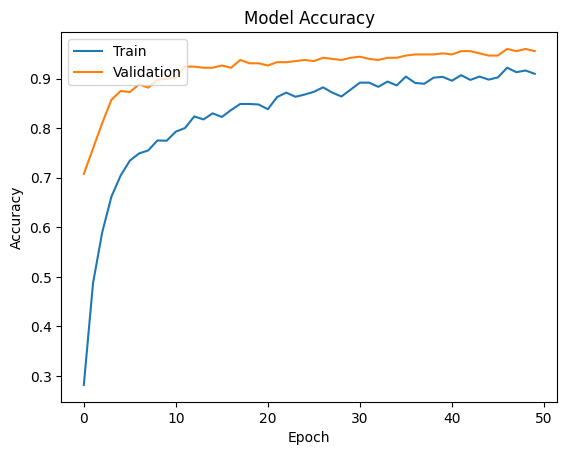

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.9022 - accuracy: 0.2227 - val_loss: 1.6286 - val_accuracy: 0.4554
Epoch 2/50
56/56 [==============================] - 0s 1000us/step - loss: 1.6198 - accuracy: 0.3845 - val_loss: 1.3591 - val_accuracy: 0.5536
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.4460 - accuracy: 0.4492 - val_loss: 1.1651 - val_accuracy: 0.6429
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2979 - accuracy: 0.5106 - val_loss: 1.0374 - val_accuracy: 0.6607
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2238 - accuracy: 0.5396 - val_loss: 0.9634 - val_accuracy: 0.6629
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 1.1345 - accuracy: 0.5692 - val_loss: 0.9016 - val_accuracy: 0.7009
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0899 - accuracy: 0.5910 - val_loss: 0.8491 - val_accuracy: 0.7098
Epoch 8/50
56/56 

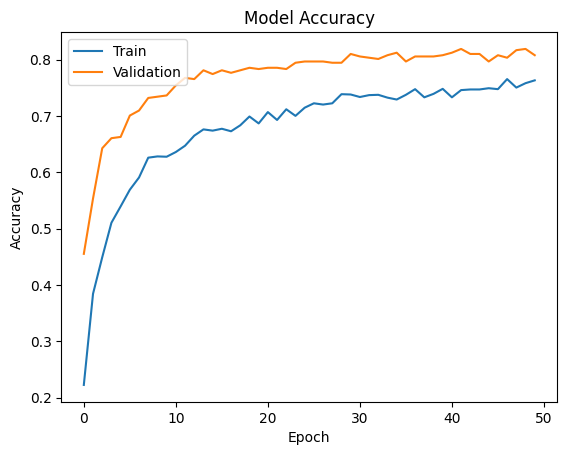

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8754 - accuracy: 0.2801 - val_loss: 1.4279 - val_accuracy: 0.5089
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.4821 - accuracy: 0.4291 - val_loss: 1.1870 - val_accuracy: 0.5982
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2992 - accuracy: 0.5279 - val_loss: 1.0197 - val_accuracy: 0.7031
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1604 - accuracy: 0.5792 - val_loss: 0.8807 - val_accuracy: 0.7321
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0246 - accuracy: 0.6110 - val_loss: 0.7767 - val_accuracy: 0.7411
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9576 - accuracy: 0.6323 - val_loss: 0.7196 - val_accuracy: 0.7679
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9016 - accuracy: 0.6496 - val_loss: 0.6643 - val_accuracy: 0.7857
Epoch 8/50
56/56 [==

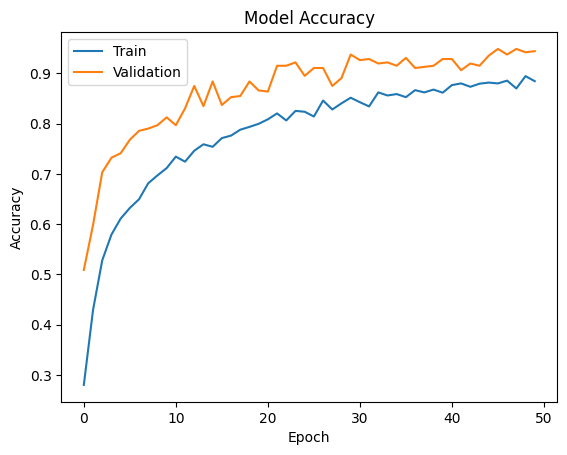

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7933 - accuracy: 0.2818 - val_loss: 1.3590 - val_accuracy: 0.6741
Epoch 2/50
56/56 [==============================] - 0s 995us/step - loss: 1.3300 - accuracy: 0.5039 - val_loss: 0.9116 - val_accuracy: 0.7879
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0616 - accuracy: 0.6049 - val_loss: 0.6707 - val_accuracy: 0.8549
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9074 - accuracy: 0.6445 - val_loss: 0.5554 - val_accuracy: 0.8638
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8106 - accuracy: 0.6981 - val_loss: 0.4792 - val_accuracy: 0.8795
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7357 - accuracy: 0.7450 - val_loss: 0.4194 - val_accuracy: 0.8839
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6902 - accuracy: 0.7321 - val_loss: 0.3782 - val_accuracy: 0.8951
Epoch 8/50
56/56 [

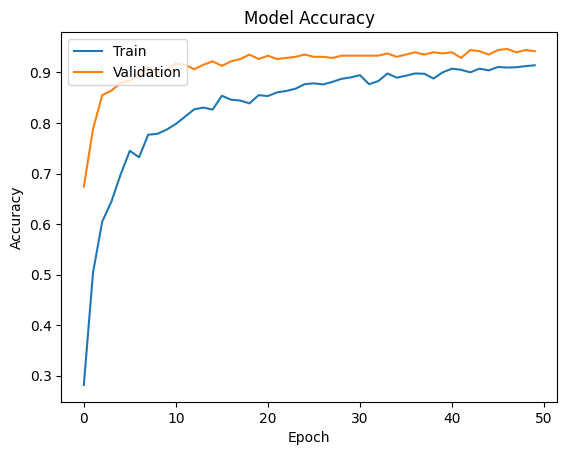

Epoch 1/50
56/56 [==============================] - 0s 3ms/step - loss: 1.8659 - accuracy: 0.3025 - val_loss: 1.2332 - val_accuracy: 0.6272
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3582 - accuracy: 0.4688 - val_loss: 0.9674 - val_accuracy: 0.7165
Epoch 3/50
56/56 [==============================] - 0s 3ms/step - loss: 1.1796 - accuracy: 0.5552 - val_loss: 0.8411 - val_accuracy: 0.7411
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0770 - accuracy: 0.5977 - val_loss: 0.7358 - val_accuracy: 0.7723
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9730 - accuracy: 0.6367 - val_loss: 0.6859 - val_accuracy: 0.7879
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8965 - accuracy: 0.6629 - val_loss: 0.6269 - val_accuracy: 0.7924
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8689 - accuracy: 0.6669 - val_loss: 0.5954 - val_accuracy: 0.8080
Epoch 8/50
56/56 [==

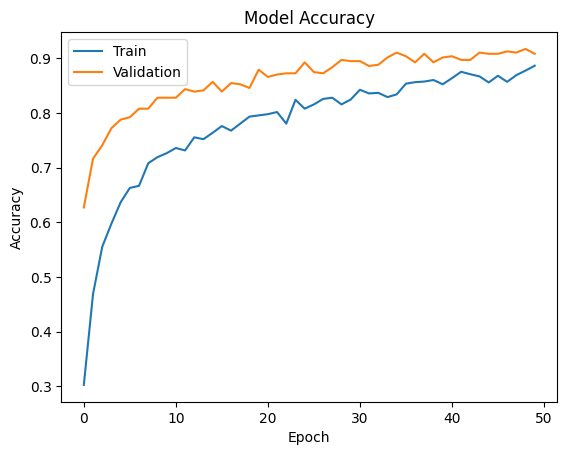

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7847 - accuracy: 0.2779 - val_loss: 1.3753 - val_accuracy: 0.6451
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3301 - accuracy: 0.5061 - val_loss: 0.9384 - val_accuracy: 0.7924
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0969 - accuracy: 0.5943 - val_loss: 0.6977 - val_accuracy: 0.8460
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9412 - accuracy: 0.6602 - val_loss: 0.5672 - val_accuracy: 0.8527
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8067 - accuracy: 0.6970 - val_loss: 0.4762 - val_accuracy: 0.8884
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7501 - accuracy: 0.7372 - val_loss: 0.4201 - val_accuracy: 0.8750
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6813 - accuracy: 0.7522 - val_loss: 0.3854 - val_accuracy: 0.8929
Epoch 8/50
56/56 [==

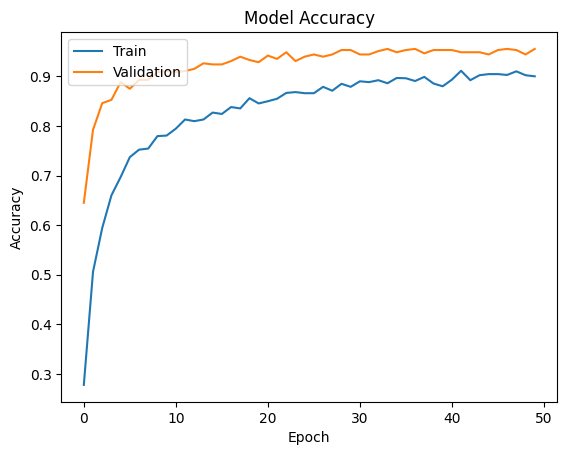

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7435 - accuracy: 0.3348 - val_loss: 1.1252 - val_accuracy: 0.7879
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2158 - accuracy: 0.5653 - val_loss: 0.7484 - val_accuracy: 0.8594
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9432 - accuracy: 0.6562 - val_loss: 0.5318 - val_accuracy: 0.8817
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7861 - accuracy: 0.7132 - val_loss: 0.4226 - val_accuracy: 0.9241
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6695 - accuracy: 0.7561 - val_loss: 0.3542 - val_accuracy: 0.9353
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5821 - accuracy: 0.7969 - val_loss: 0.3214 - val_accuracy: 0.9129
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5295 - accuracy: 0.8052 - val_loss: 0.2842 - val_accuracy: 0.9241
Epoch 8/50
56/56 [==

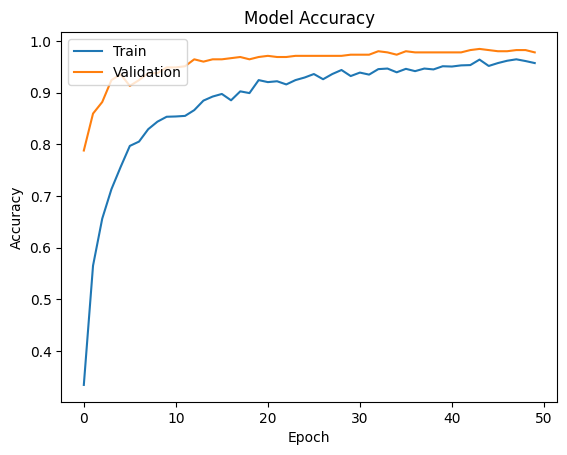

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8335 - accuracy: 0.2695 - val_loss: 1.4352 - val_accuracy: 0.7143
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3712 - accuracy: 0.5128 - val_loss: 0.9295 - val_accuracy: 0.7455
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1063 - accuracy: 0.5876 - val_loss: 0.6980 - val_accuracy: 0.8438
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9205 - accuracy: 0.6735 - val_loss: 0.5720 - val_accuracy: 0.8371
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8050 - accuracy: 0.6970 - val_loss: 0.4885 - val_accuracy: 0.8616
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7478 - accuracy: 0.7238 - val_loss: 0.4388 - val_accuracy: 0.8661
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6982 - accuracy: 0.7494 - val_loss: 0.4019 - val_accuracy: 0.8750
Epoch 8/50
56/56 [==

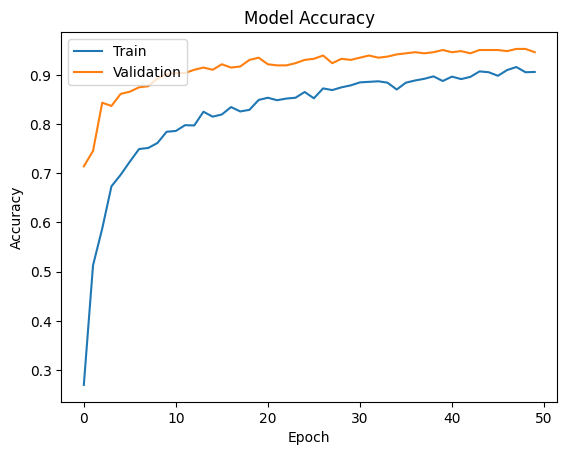

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8722 - accuracy: 0.2980 - val_loss: 1.0955 - val_accuracy: 0.7188
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2777 - accuracy: 0.5385 - val_loss: 0.7343 - val_accuracy: 0.8348
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9803 - accuracy: 0.6535 - val_loss: 0.5015 - val_accuracy: 0.8996
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7976 - accuracy: 0.6981 - val_loss: 0.3745 - val_accuracy: 0.9241
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6566 - accuracy: 0.7667 - val_loss: 0.2948 - val_accuracy: 0.9308
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5537 - accuracy: 0.7930 - val_loss: 0.2458 - val_accuracy: 0.9308
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4755 - accuracy: 0.8276 - val_loss: 0.2250 - val_accuracy: 0.9353
Epoch 8/50
56/56 [==

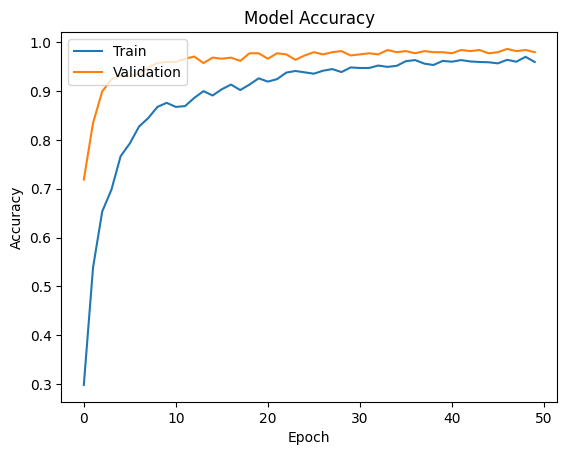

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.9074 - accuracy: 0.2673 - val_loss: 1.3562 - val_accuracy: 0.6719
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.4001 - accuracy: 0.4648 - val_loss: 0.9924 - val_accuracy: 0.7567
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1322 - accuracy: 0.5882 - val_loss: 0.7555 - val_accuracy: 0.8036
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9495 - accuracy: 0.6445 - val_loss: 0.6090 - val_accuracy: 0.8304
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8230 - accuracy: 0.6948 - val_loss: 0.5182 - val_accuracy: 0.8638
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7620 - accuracy: 0.7199 - val_loss: 0.4633 - val_accuracy: 0.8705
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6748 - accuracy: 0.7545 - val_loss: 0.4217 - val_accuracy: 0.8795
Epoch 8/50
56/56 [==

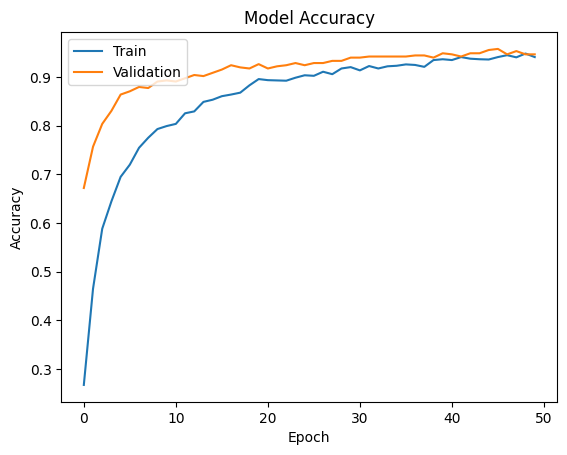

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8676 - accuracy: 0.2394 - val_loss: 1.6242 - val_accuracy: 0.4710
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.6320 - accuracy: 0.3962 - val_loss: 1.4043 - val_accuracy: 0.5893
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.4606 - accuracy: 0.4581 - val_loss: 1.2129 - val_accuracy: 0.6295
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3185 - accuracy: 0.5128 - val_loss: 1.0581 - val_accuracy: 0.6540
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2420 - accuracy: 0.5552 - val_loss: 0.9768 - val_accuracy: 0.6853
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1473 - accuracy: 0.5798 - val_loss: 0.9167 - val_accuracy: 0.7098
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1075 - accuracy: 0.5932 - val_loss: 0.8726 - val_accuracy: 0.7143
Epoch 8/50
56/56 [==

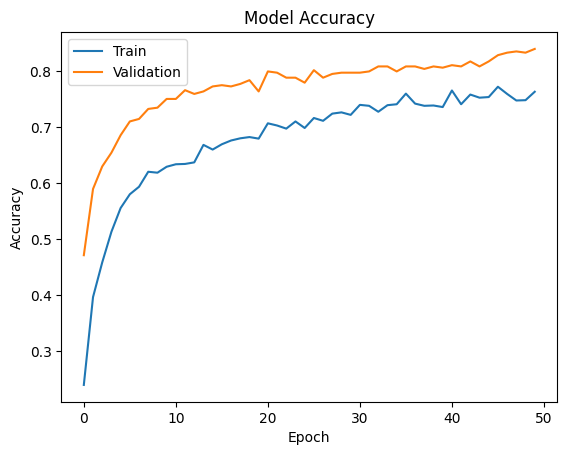

Epoch 1/50
56/56 [==============================] - 1s 7ms/step - loss: 1.8306 - accuracy: 0.3237 - val_loss: 1.1467 - val_accuracy: 0.6652
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3181 - accuracy: 0.5078 - val_loss: 0.8680 - val_accuracy: 0.7455
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1099 - accuracy: 0.6161 - val_loss: 0.6772 - val_accuracy: 0.8170
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9025 - accuracy: 0.6836 - val_loss: 0.5375 - val_accuracy: 0.8527
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7956 - accuracy: 0.7243 - val_loss: 0.4590 - val_accuracy: 0.8929
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6877 - accuracy: 0.7539 - val_loss: 0.4084 - val_accuracy: 0.8951
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6395 - accuracy: 0.7773 - val_loss: 0.3633 - val_accuracy: 0.8973
Epoch 8/50
56/56 [==

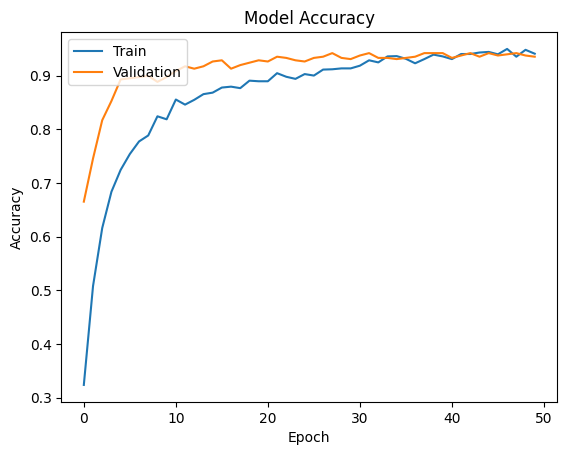

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8854 - accuracy: 0.2701 - val_loss: 1.4797 - val_accuracy: 0.5603
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.5370 - accuracy: 0.4280 - val_loss: 1.2311 - val_accuracy: 0.6138
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3246 - accuracy: 0.5145 - val_loss: 1.0436 - val_accuracy: 0.7098
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1652 - accuracy: 0.5664 - val_loss: 0.8898 - val_accuracy: 0.7478
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0711 - accuracy: 0.6144 - val_loss: 0.8051 - val_accuracy: 0.7879
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9943 - accuracy: 0.6356 - val_loss: 0.7337 - val_accuracy: 0.7746
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9048 - accuracy: 0.6613 - val_loss: 0.6712 - val_accuracy: 0.8013
Epoch 8/50
56/56 [==

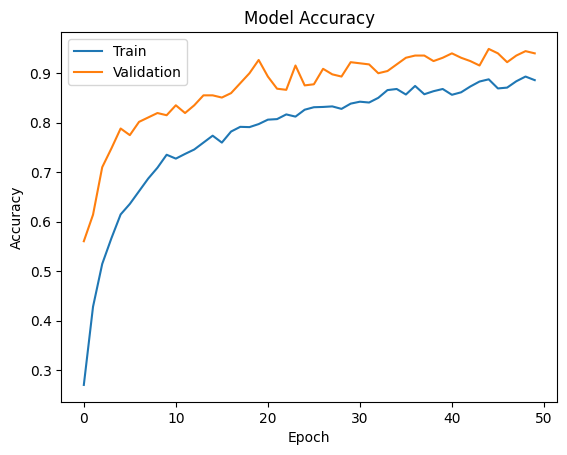

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7438 - accuracy: 0.3471 - val_loss: 1.0940 - val_accuracy: 0.6875
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2179 - accuracy: 0.5374 - val_loss: 0.8560 - val_accuracy: 0.7656
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0719 - accuracy: 0.6083 - val_loss: 0.6837 - val_accuracy: 0.8147
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9003 - accuracy: 0.6747 - val_loss: 0.5611 - val_accuracy: 0.8438
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7631 - accuracy: 0.7182 - val_loss: 0.4594 - val_accuracy: 0.8884
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6903 - accuracy: 0.7589 - val_loss: 0.4101 - val_accuracy: 0.8906
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6334 - accuracy: 0.7723 - val_loss: 0.3569 - val_accuracy: 0.9018
Epoch 8/50
56/56 [==

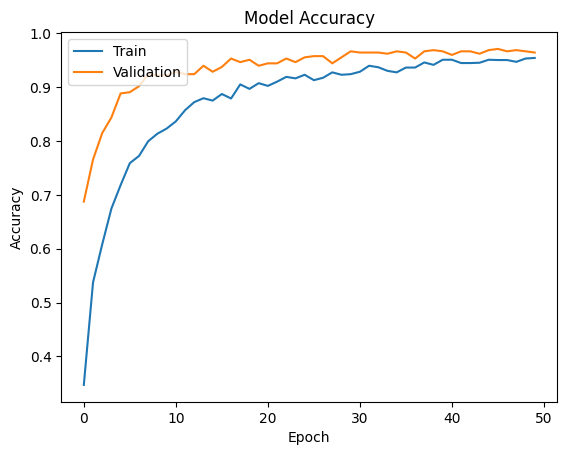

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8388 - accuracy: 0.3354 - val_loss: 1.1045 - val_accuracy: 0.6875
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2482 - accuracy: 0.5552 - val_loss: 0.7616 - val_accuracy: 0.8170
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9588 - accuracy: 0.6641 - val_loss: 0.5362 - val_accuracy: 0.8571
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7964 - accuracy: 0.7249 - val_loss: 0.4277 - val_accuracy: 0.8795
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6727 - accuracy: 0.7612 - val_loss: 0.3381 - val_accuracy: 0.9085
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6049 - accuracy: 0.7835 - val_loss: 0.2940 - val_accuracy: 0.9174
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5037 - accuracy: 0.8164 - val_loss: 0.2576 - val_accuracy: 0.9107
Epoch 8/50
56/56 [==

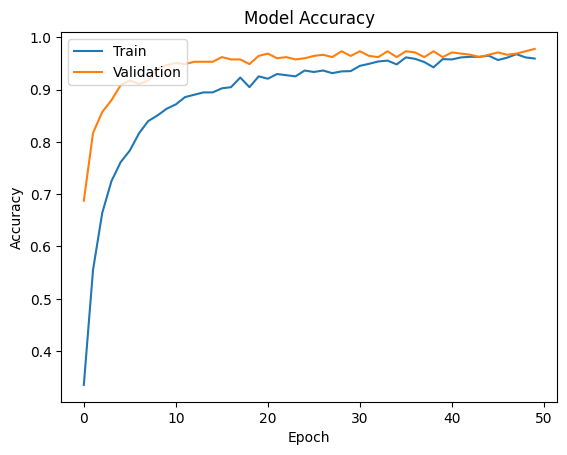

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8662 - accuracy: 0.2846 - val_loss: 1.3315 - val_accuracy: 0.7478
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3316 - accuracy: 0.5145 - val_loss: 0.8289 - val_accuracy: 0.8996
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9460 - accuracy: 0.6708 - val_loss: 0.4888 - val_accuracy: 0.9241
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7166 - accuracy: 0.7584 - val_loss: 0.3396 - val_accuracy: 0.9330
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6204 - accuracy: 0.7941 - val_loss: 0.2673 - val_accuracy: 0.9442
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5596 - accuracy: 0.8108 - val_loss: 0.2242 - val_accuracy: 0.9509
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4782 - accuracy: 0.8265 - val_loss: 0.1965 - val_accuracy: 0.9531
Epoch 8/50
56/56 [==

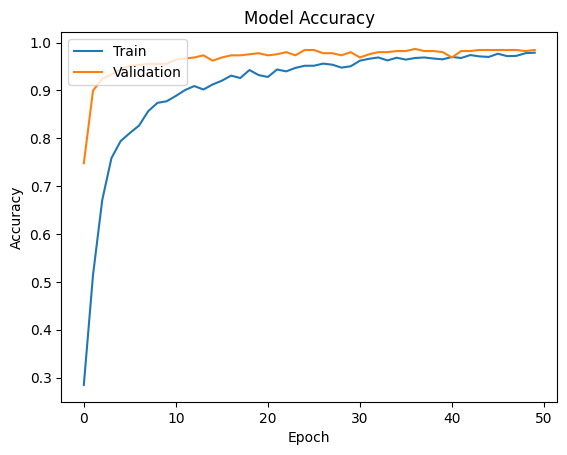

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7962 - accuracy: 0.2874 - val_loss: 1.3681 - val_accuracy: 0.7121
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3709 - accuracy: 0.5067 - val_loss: 0.9312 - val_accuracy: 0.7812
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0906 - accuracy: 0.6094 - val_loss: 0.7060 - val_accuracy: 0.8013
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9314 - accuracy: 0.6496 - val_loss: 0.5755 - val_accuracy: 0.8371
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8249 - accuracy: 0.6959 - val_loss: 0.4898 - val_accuracy: 0.8616
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7349 - accuracy: 0.7171 - val_loss: 0.4387 - val_accuracy: 0.8683
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7104 - accuracy: 0.7400 - val_loss: 0.3978 - val_accuracy: 0.8750
Epoch 8/50
56/56 [==

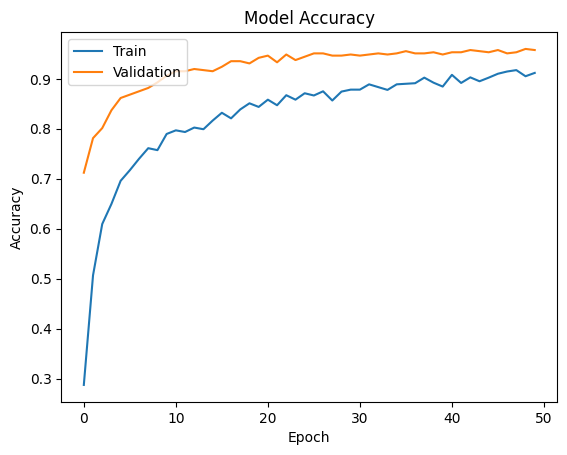

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7508 - accuracy: 0.3510 - val_loss: 0.9638 - val_accuracy: 0.7991
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1070 - accuracy: 0.6077 - val_loss: 0.5808 - val_accuracy: 0.8795
Epoch 3/50
56/56 [==============================] - 0s 2ms/step - loss: 0.8340 - accuracy: 0.7210 - val_loss: 0.3809 - val_accuracy: 0.9062
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6086 - accuracy: 0.7868 - val_loss: 0.2779 - val_accuracy: 0.9219
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5416 - accuracy: 0.8080 - val_loss: 0.2175 - val_accuracy: 0.9330
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4431 - accuracy: 0.8504 - val_loss: 0.1823 - val_accuracy: 0.9353
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.3981 - accuracy: 0.8594 - val_loss: 0.1652 - val_accuracy: 0.9531
Epoch 8/50
56/56 [==

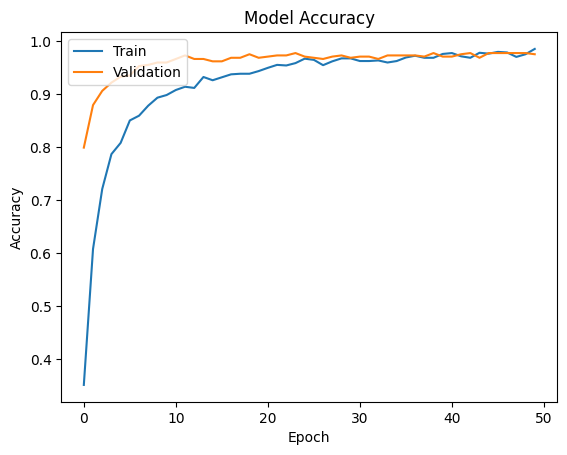

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8659 - accuracy: 0.2840 - val_loss: 1.2595 - val_accuracy: 0.6964
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2696 - accuracy: 0.5273 - val_loss: 0.8302 - val_accuracy: 0.8237
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9855 - accuracy: 0.6194 - val_loss: 0.5965 - val_accuracy: 0.8638
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7925 - accuracy: 0.7109 - val_loss: 0.4656 - val_accuracy: 0.8638
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.7344 - val_loss: 0.3882 - val_accuracy: 0.8951
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6084 - accuracy: 0.7695 - val_loss: 0.3386 - val_accuracy: 0.8906
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5570 - accuracy: 0.7824 - val_loss: 0.3052 - val_accuracy: 0.9129
Epoch 8/50
56/56 [==

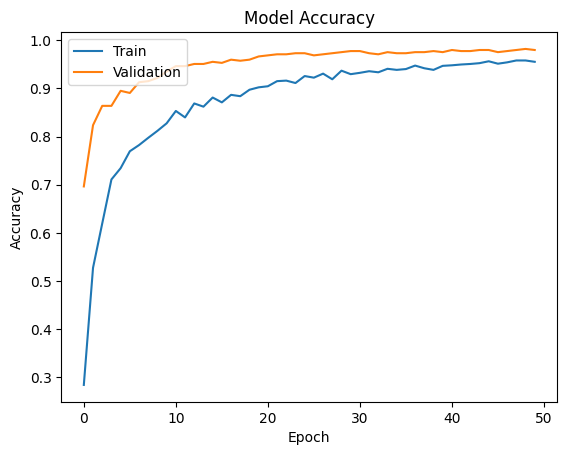

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8129 - accuracy: 0.3304 - val_loss: 1.0772 - val_accuracy: 0.7679
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2070 - accuracy: 0.5658 - val_loss: 0.6636 - val_accuracy: 0.8616
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8615 - accuracy: 0.7003 - val_loss: 0.4396 - val_accuracy: 0.8996
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.7617 - val_loss: 0.3244 - val_accuracy: 0.9286
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5594 - accuracy: 0.7935 - val_loss: 0.2595 - val_accuracy: 0.9397
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4467 - accuracy: 0.8365 - val_loss: 0.2188 - val_accuracy: 0.9442
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4365 - accuracy: 0.8510 - val_loss: 0.1761 - val_accuracy: 0.9531
Epoch 8/50
56/56 [==

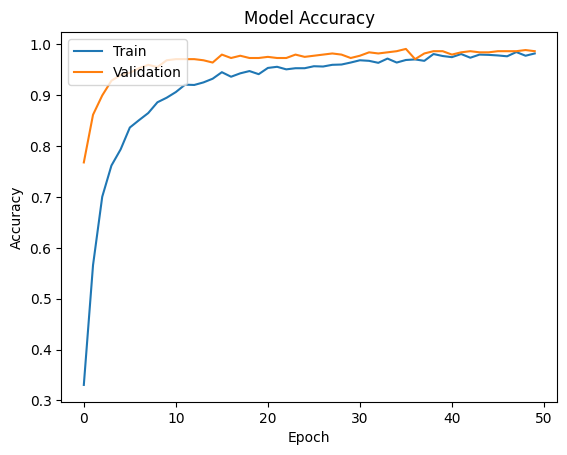

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8199 - accuracy: 0.3320 - val_loss: 1.0022 - val_accuracy: 0.7790
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1364 - accuracy: 0.5703 - val_loss: 0.6396 - val_accuracy: 0.8571
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8755 - accuracy: 0.6914 - val_loss: 0.4331 - val_accuracy: 0.8996
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6800 - accuracy: 0.7533 - val_loss: 0.3343 - val_accuracy: 0.9018
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5471 - accuracy: 0.8080 - val_loss: 0.2794 - val_accuracy: 0.9219
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.8309 - val_loss: 0.2437 - val_accuracy: 0.9330
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4598 - accuracy: 0.8309 - val_loss: 0.2137 - val_accuracy: 0.9420
Epoch 8/50
56/56 [==

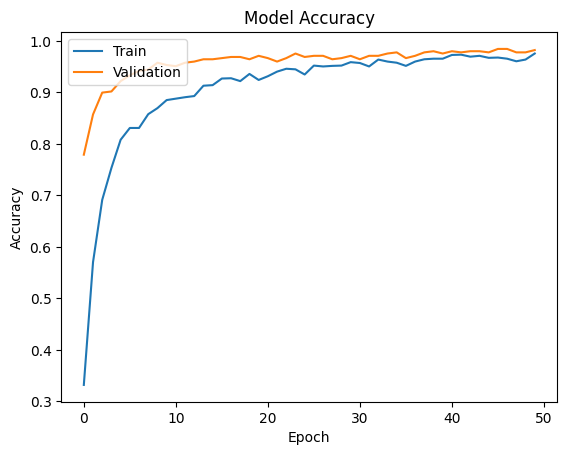

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.9122 - accuracy: 0.2561 - val_loss: 1.4073 - val_accuracy: 0.6429
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.4394 - accuracy: 0.4554 - val_loss: 1.0508 - val_accuracy: 0.7344
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1661 - accuracy: 0.5960 - val_loss: 0.8030 - val_accuracy: 0.8013
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9783 - accuracy: 0.6401 - val_loss: 0.6300 - val_accuracy: 0.8460
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8362 - accuracy: 0.7020 - val_loss: 0.5369 - val_accuracy: 0.8638
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7282 - accuracy: 0.7433 - val_loss: 0.4631 - val_accuracy: 0.8683
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6812 - accuracy: 0.7684 - val_loss: 0.4086 - val_accuracy: 0.8728
Epoch 8/50
56/56 [==

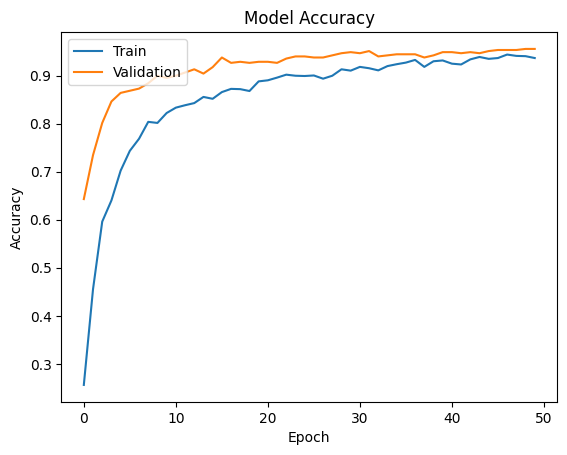

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.9458 - accuracy: 0.2919 - val_loss: 1.1449 - val_accuracy: 0.7433
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2421 - accuracy: 0.5519 - val_loss: 0.7325 - val_accuracy: 0.8750
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9392 - accuracy: 0.6719 - val_loss: 0.5201 - val_accuracy: 0.9062
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7443 - accuracy: 0.7416 - val_loss: 0.3901 - val_accuracy: 0.9219
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6362 - accuracy: 0.7907 - val_loss: 0.2897 - val_accuracy: 0.9464
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5438 - accuracy: 0.8142 - val_loss: 0.2664 - val_accuracy: 0.9442
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.8371 - val_loss: 0.2263 - val_accuracy: 0.9487
Epoch 8/50
56/56 [==

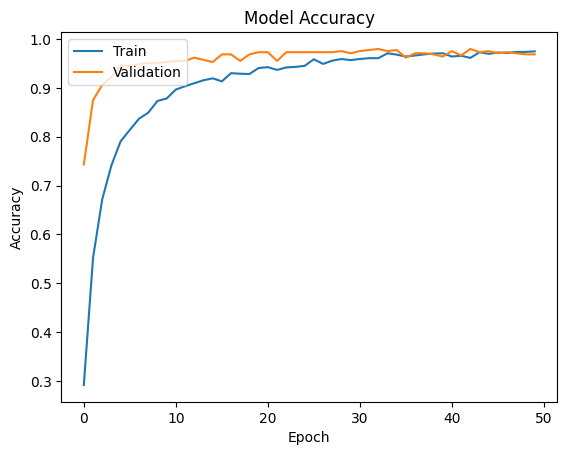

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7710 - accuracy: 0.3488 - val_loss: 0.9981 - val_accuracy: 0.7812
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1342 - accuracy: 0.5988 - val_loss: 0.6086 - val_accuracy: 0.8683
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8705 - accuracy: 0.7059 - val_loss: 0.4081 - val_accuracy: 0.9040
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6777 - accuracy: 0.7550 - val_loss: 0.3010 - val_accuracy: 0.9286
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5425 - accuracy: 0.8142 - val_loss: 0.2331 - val_accuracy: 0.9375
Epoch 6/50
56/56 [==============================] - 0s 3ms/step - loss: 0.4565 - accuracy: 0.8449 - val_loss: 0.2106 - val_accuracy: 0.9397
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.3997 - accuracy: 0.8594 - val_loss: 0.1877 - val_accuracy: 0.9397
Epoch 8/50
56/56 [==

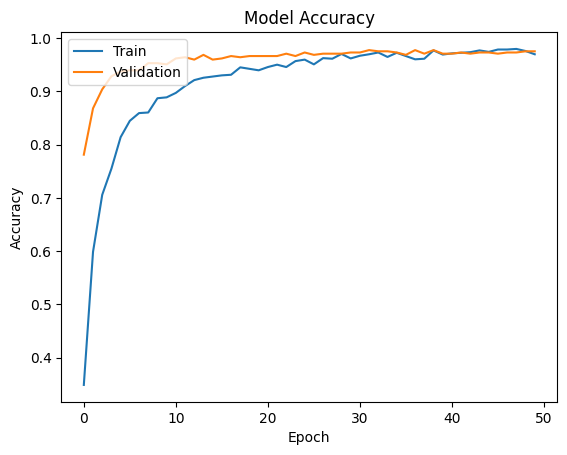

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8824 - accuracy: 0.3304 - val_loss: 1.0966 - val_accuracy: 0.7433
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1991 - accuracy: 0.5541 - val_loss: 0.6983 - val_accuracy: 0.8884
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8773 - accuracy: 0.6864 - val_loss: 0.4485 - val_accuracy: 0.9085
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7167 - accuracy: 0.7383 - val_loss: 0.3411 - val_accuracy: 0.9263
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5584 - accuracy: 0.7974 - val_loss: 0.2421 - val_accuracy: 0.9442
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4582 - accuracy: 0.8382 - val_loss: 0.2066 - val_accuracy: 0.9531
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4192 - accuracy: 0.8477 - val_loss: 0.1940 - val_accuracy: 0.9643
Epoch 8/50
56/56 [==

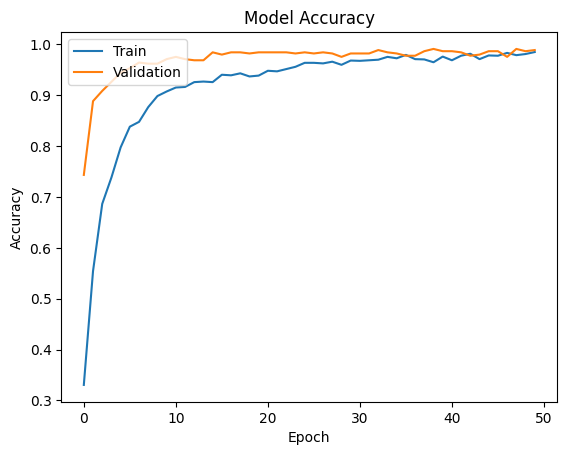

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7974 - accuracy: 0.3097 - val_loss: 1.2023 - val_accuracy: 0.7545
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2457 - accuracy: 0.5552 - val_loss: 0.7602 - val_accuracy: 0.8616
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9536 - accuracy: 0.6490 - val_loss: 0.5159 - val_accuracy: 0.9018
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7649 - accuracy: 0.7338 - val_loss: 0.3721 - val_accuracy: 0.9308
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6486 - accuracy: 0.7790 - val_loss: 0.2951 - val_accuracy: 0.9420
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5535 - accuracy: 0.7985 - val_loss: 0.2496 - val_accuracy: 0.9487
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4638 - accuracy: 0.8410 - val_loss: 0.2114 - val_accuracy: 0.9509
Epoch 8/50
56/56 [==

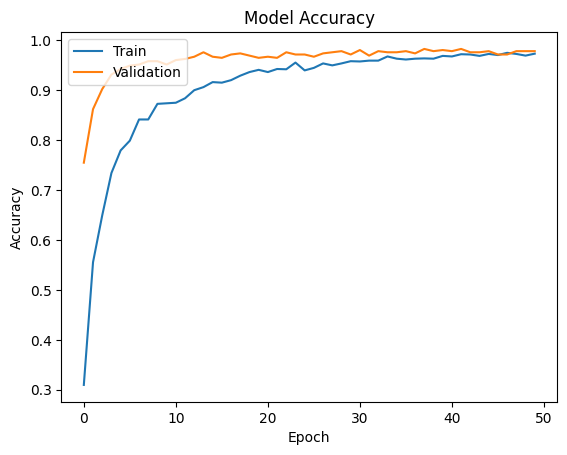

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8956 - accuracy: 0.2907 - val_loss: 1.2331 - val_accuracy: 0.7433
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2659 - accuracy: 0.5346 - val_loss: 0.7804 - val_accuracy: 0.8996
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.9290 - accuracy: 0.6702 - val_loss: 0.4819 - val_accuracy: 0.9308
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6843 - accuracy: 0.7640 - val_loss: 0.3165 - val_accuracy: 0.9375
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5406 - accuracy: 0.8075 - val_loss: 0.2219 - val_accuracy: 0.9509
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4206 - accuracy: 0.8700 - val_loss: 0.1625 - val_accuracy: 0.9643
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.3416 - accuracy: 0.8884 - val_loss: 0.1395 - val_accuracy: 0.9710
Epoch 8/50
56/56 [==

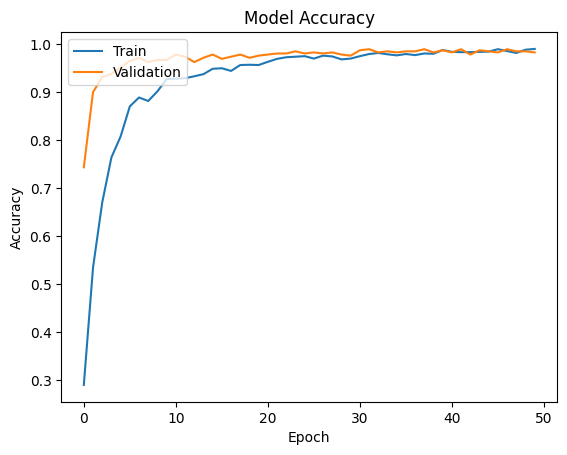

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8752 - accuracy: 0.3058 - val_loss: 1.1128 - val_accuracy: 0.7656
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1845 - accuracy: 0.5703 - val_loss: 0.6111 - val_accuracy: 0.8728
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8462 - accuracy: 0.7126 - val_loss: 0.3808 - val_accuracy: 0.8951
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6554 - accuracy: 0.7768 - val_loss: 0.2748 - val_accuracy: 0.9286
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5278 - accuracy: 0.8114 - val_loss: 0.2116 - val_accuracy: 0.9487
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4258 - accuracy: 0.8454 - val_loss: 0.1680 - val_accuracy: 0.9531
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.3957 - accuracy: 0.8638 - val_loss: 0.1567 - val_accuracy: 0.9621
Epoch 8/50
56/56 [==

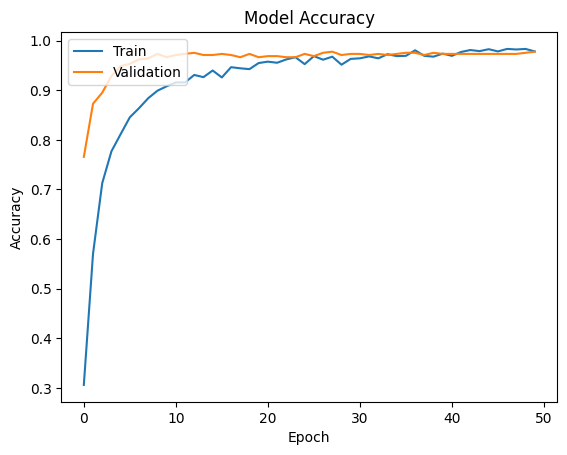

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.7831 - accuracy: 0.3477 - val_loss: 0.9526 - val_accuracy: 0.8438
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0886 - accuracy: 0.6088 - val_loss: 0.5451 - val_accuracy: 0.9085
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7317 - accuracy: 0.7366 - val_loss: 0.3400 - val_accuracy: 0.9263
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5691 - accuracy: 0.7958 - val_loss: 0.2541 - val_accuracy: 0.9375
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4818 - accuracy: 0.8292 - val_loss: 0.2188 - val_accuracy: 0.9464
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4153 - accuracy: 0.8454 - val_loss: 0.1896 - val_accuracy: 0.9665
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.3417 - accuracy: 0.8828 - val_loss: 0.1682 - val_accuracy: 0.9688
Epoch 8/50
56/56 [==

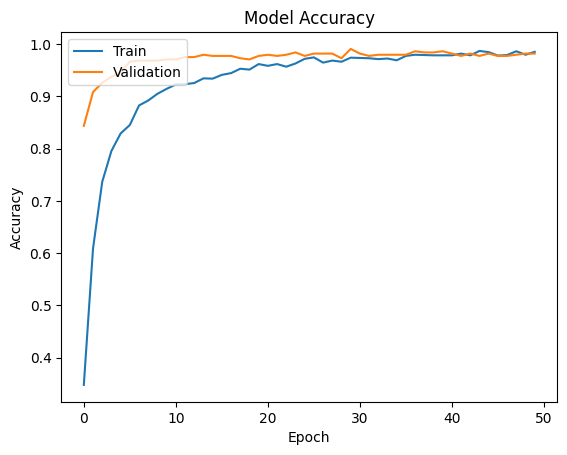

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.9184 - accuracy: 0.3064 - val_loss: 1.1490 - val_accuracy: 0.8214
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1588 - accuracy: 0.5988 - val_loss: 0.6095 - val_accuracy: 0.9062
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8035 - accuracy: 0.7193 - val_loss: 0.3637 - val_accuracy: 0.9353
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5947 - accuracy: 0.7952 - val_loss: 0.2547 - val_accuracy: 0.9464
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.8376 - val_loss: 0.1853 - val_accuracy: 0.9420
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.3894 - accuracy: 0.8638 - val_loss: 0.1651 - val_accuracy: 0.9487
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.3216 - accuracy: 0.8834 - val_loss: 0.1412 - val_accuracy: 0.9509
Epoch 8/50
56/56 [==

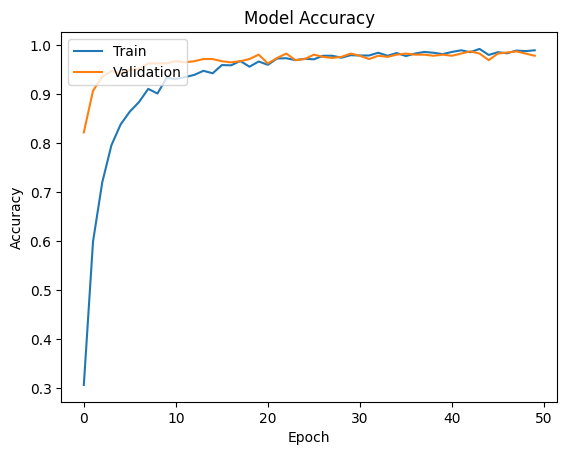

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8167 - accuracy: 0.3354 - val_loss: 1.0029 - val_accuracy: 0.8438
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0911 - accuracy: 0.6060 - val_loss: 0.5428 - val_accuracy: 0.9196
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7290 - accuracy: 0.7467 - val_loss: 0.3455 - val_accuracy: 0.9308
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5811 - accuracy: 0.7974 - val_loss: 0.2450 - val_accuracy: 0.9509
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 0.4589 - accuracy: 0.8449 - val_loss: 0.1878 - val_accuracy: 0.9621
Epoch 6/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3919 - accuracy: 0.8599 - val_loss: 0.1669 - val_accuracy: 0.9621
Epoch 7/50
56/56 [==============================] - 0s 2ms/step - loss: 0.3200 - accuracy: 0.8862 - val_loss: 0.1522 - val_accuracy: 0.9621
Epoch 8/50
56/56 [==

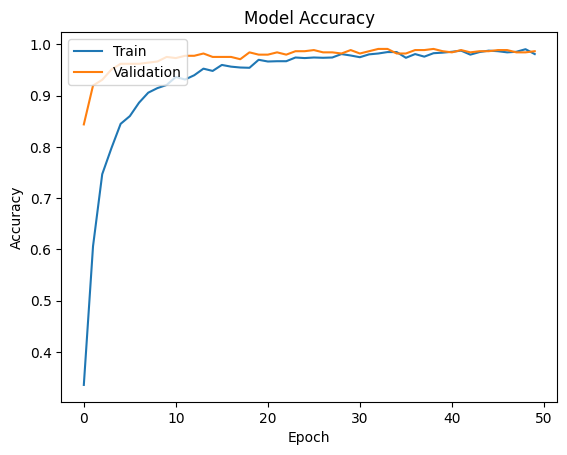

,Feature Set,Accuracy,Precision,Recall,F1
0,mfcc,0.958929,0.959367,0.958929,0.958775
1,lpcc,0.817857,0.825317,0.817857,0.818671
2,lfpc,0.935714,0.935984,0.935714,0.934786
3,gfcc,0.950000,0.951098,0.950000,0.950046
4,formants,0.900000,0.899989,0.900000,0.899379
5,mfcc+lpcc,0.967857,0.968630,0.967857,0.967879
6,mfcc+lfpc,0.982143,0.982450,0.982143,0.982093
7,mfcc+gfcc,0.960714,0.962062,0.960714,0.960568
8,mfcc+formants,0.978571,0.978676,0.978571,0.978534
9,lpcc+lfpc,0.962500,0.963130,0.962500,0.962391


In [53]:
# Run analysis on acoustic features
acoustic_feature_set = 'features/acoustic_features.csv'
print(f"Evaluating feature set: {acoustic_feature_set}")
run_acoustic_analysis_ann_combinations(acoustic_feature_set)

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8642 - accuracy: 0.3265 - val_loss: 0.9552 - val_accuracy: 0.8460
Epoch 2/50
56/56 [==============================] - 0s 974us/step - loss: 1.0917 - accuracy: 0.6110 - val_loss: 0.4974 - val_accuracy: 0.9263
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7288 - accuracy: 0.7439 - val_loss: 0.2651 - val_accuracy: 0.9576
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.5343 - accuracy: 0.8181 - val_loss: 0.1730 - val_accuracy: 0.9621
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.4111 - accuracy: 0.8627 - val_loss: 0.1376 - val_accuracy: 0.9710
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.3263 - accuracy: 0.8884 - val_loss: 0.1202 - val_accuracy: 0.9710
Epoch 7/50
56/56 [==============================] - 0s 997us/step - loss: 0.2453 - accuracy: 0.9208 - val_loss: 0.1033 - val_accuracy: 0.9777
Epoch 8/50
56/56

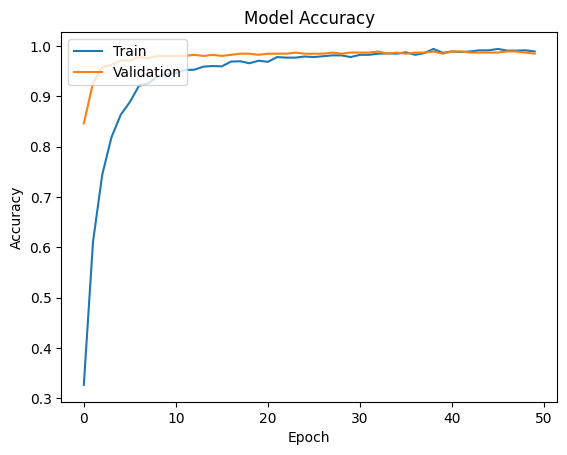

{'angry': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 88.0}, 'disgust': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 86.0}, 'fear': {'precision': 1.0, 'recall': 0.984375, 'f1-score': 0.9921259842519685, 'support': 64.0}, 'happy': {'precision': 0.9883720930232558, 'recall': 1.0, 'f1-score': 0.9941520467836257, 'support': 85.0}, 'neutral': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 66.0}, 'ps': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 89.0}, 'sad': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 82.0}, 'accuracy': 0.9982142857142857, 'macro avg': {'precision': 0.9983388704318937, 'recall': 0.9977678571428571, 'f1-score': 0.9980397187193706, 'support': 560.0}, 'weighted avg': {'precision': 0.998235049833887, 'recall': 0.9982142857142857, 'f1-score': 0.9982124767298826, 'support': 560.0}}


In [73]:
prosodic_feature_set = 'features/prosodic_features.csv'
acoustic_feature_set = 'features/acoustic_features.csv'
model, report = run_combined_analysis(acoustic_csv_file=acoustic_feature_set, prosodic_csv_file=prosodic_feature_set)
print(report)

Evaluating feature set: features/prosodic_features.csv
Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8380 - accuracy: 0.2467 - val_loss: 1.6463 - val_accuracy: 0.3237
Epoch 2/50
56/56 [==============================] - 0s 992us/step - loss: 1.6134 - accuracy: 0.3203 - val_loss: 1.4706 - val_accuracy: 0.3906
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.5282 - accuracy: 0.3354 - val_loss: 1.4054 - val_accuracy: 0.4129
Epoch 4/50
56/56 [==============================] - 0s 995us/step - loss: 1.4756 - accuracy: 0.3677 - val_loss: 1.3596 - val_accuracy: 0.4196
Epoch 5/50
56/56 [==============================] - 0s 986us/step - loss: 1.4508 - accuracy: 0.3610 - val_loss: 1.3225 - val_accuracy: 0.4353
Epoch 6/50
56/56 [==============================] - 0s 973us/step - loss: 1.4059 - accuracy: 0.3968 - val_loss: 1.2978 - val_accuracy: 0.4219
Epoch 7/50
56/56 [==============================] - 0s 982us/step - loss: 1.3883 - accuracy: 0.37

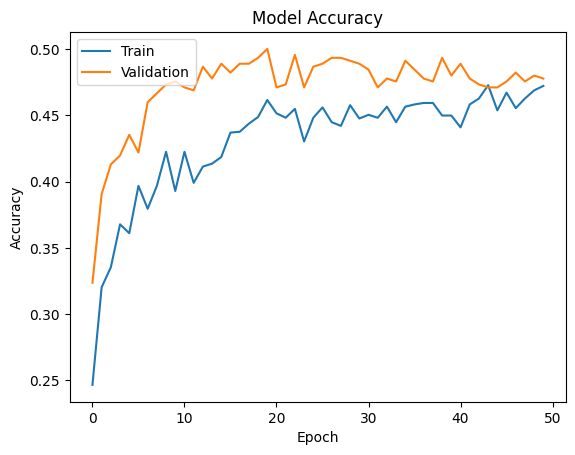

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.9344 - accuracy: 0.1691 - val_loss: 1.8689 - val_accuracy: 0.2366
Epoch 2/50
56/56 [==============================] - 0s 967us/step - loss: 1.8777 - accuracy: 0.1959 - val_loss: 1.8252 - val_accuracy: 0.2299
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.8452 - accuracy: 0.2227 - val_loss: 1.7904 - val_accuracy: 0.2679
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 1.8232 - accuracy: 0.2316 - val_loss: 1.7607 - val_accuracy: 0.2969
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 1.7992 - accuracy: 0.2623 - val_loss: 1.7418 - val_accuracy: 0.3304
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 1.7658 - accuracy: 0.2690 - val_loss: 1.7102 - val_accuracy: 0.3728
Epoch 7/50
56/56 [==============================] - 0s 999us/step - loss: 1.7414 - accuracy: 0.2706 - val_loss: 1.6887 - val_accuracy: 0.3638
Epoch 8/50
56/56

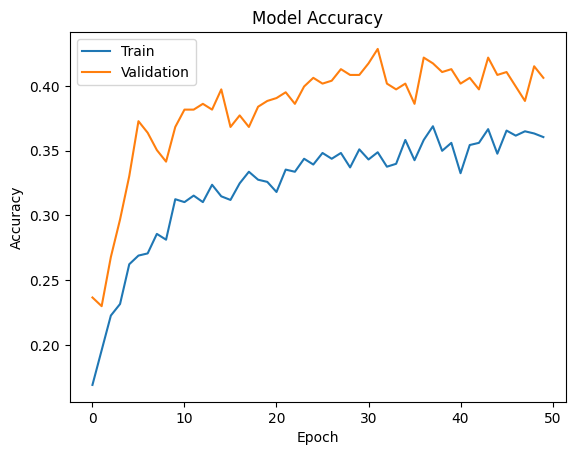

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8454 - accuracy: 0.2333 - val_loss: 1.6186 - val_accuracy: 0.4241
Epoch 2/50
56/56 [==============================] - 0s 978us/step - loss: 1.6050 - accuracy: 0.3343 - val_loss: 1.4163 - val_accuracy: 0.4442
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 1.4818 - accuracy: 0.3878 - val_loss: 1.3021 - val_accuracy: 0.4621
Epoch 4/50
56/56 [==============================] - 0s 970us/step - loss: 1.4090 - accuracy: 0.3990 - val_loss: 1.2181 - val_accuracy: 0.5000
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3692 - accuracy: 0.4035 - val_loss: 1.1591 - val_accuracy: 0.5246
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 1.3099 - accuracy: 0.4364 - val_loss: 1.1202 - val_accuracy: 0.5312
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2852 - accuracy: 0.4509 - val_loss: 1.0973 - val_accuracy: 0.5067
Epoch 8/50
56/56

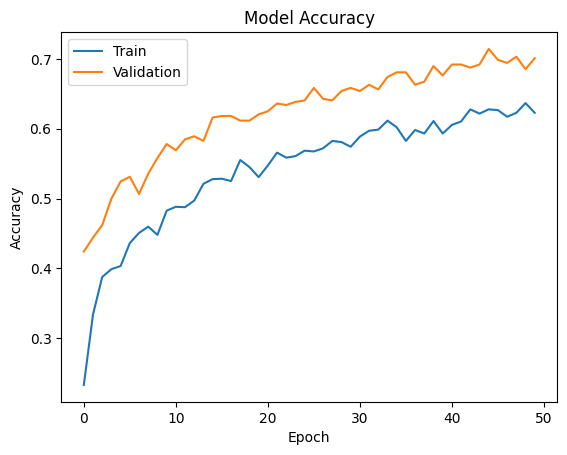

Epoch 1/50
56/56 [==============================] - 0s 2ms/step - loss: 1.8242 - accuracy: 0.2651 - val_loss: 1.5147 - val_accuracy: 0.4933
Epoch 2/50
56/56 [==============================] - 0s 953us/step - loss: 1.5464 - accuracy: 0.3756 - val_loss: 1.2471 - val_accuracy: 0.5647
Epoch 3/50
56/56 [==============================] - 0s 991us/step - loss: 1.3418 - accuracy: 0.4621 - val_loss: 1.0907 - val_accuracy: 0.6004
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 1.2260 - accuracy: 0.4972 - val_loss: 0.9891 - val_accuracy: 0.6451
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1750 - accuracy: 0.5056 - val_loss: 0.9411 - val_accuracy: 0.6496
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 1.1040 - accuracy: 0.5536 - val_loss: 0.8953 - val_accuracy: 0.6741
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 1.0903 - accuracy: 0.5385 - val_loss: 0.8648 - val_accuracy: 0.6652
Epoch 8/50
56/56

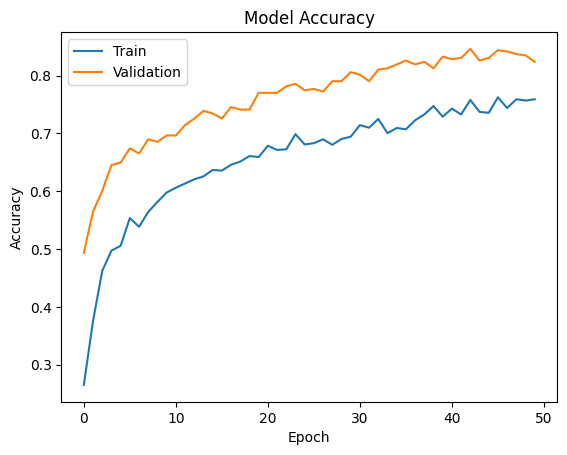

,Feature Set,Accuracy,Precision,Recall,F1
0,mean_pitch+speech_rate+duration,0.489286,0.520284,0.489286,0.456615
1,mean_pitch+std_pitch+pitch_variation,0.416071,0.408422,0.416071,0.407828
2,speech_rate+silence_duration+voiced_duration+u...,0.667857,0.692144,0.667857,0.660552
3,mean_pitch+std_pitch+mean_energy+std_energy+du...,0.823214,0.834133,0.823214,0.823882


In [61]:
prosodic_feature_set = 'features/prosodic_features.csv'
print(f"Evaluating feature set: {prosodic_feature_set}")
run_prosodic_analysis_ann_combinations(prosodic_feature_set)